In [4]:
!pip install scanpy scikit-misc scvi-tools mplscience igraph leidenalg


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!nohup python train_scvi.py > output.log 2>&1 &

In [1]:
import os
os.chdir('/workspace')
import gc
import warnings
warnings.filterwarnings("ignore")

# single cell pipelines
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

# scvi-tools
import scvi
import torch

print(scvi.__version__)
sc.logging.print_header()

np.random.seed(777)
torch.manual_seed(777)
scvi.settings.seed = 777

torch.set_float32_matmul_precision("high")

1.2.2.post2


Seed set to 777


scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.3 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [12]:
adata = sc.read_h5ad('full_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 1135345 × 5000
    obs: 'author', 'method', 'assay', 'donor_id', 'gs_prediction_main', 'SingleR', 'predicted.annotation_level_3', 'predicted.annotation_level_4.score', 'predicted.annotation_level_4', 'copykat', 'cell_type'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [3]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts", batch_key="author", labels_key="cell_type")

In [9]:
# scvi_model = scvi.model.SCVI(
#     adata,
#     n_layers=2,
#     encode_covariates=True,
#     deeply_inject_covariates=False,
#     use_layer_norm="both",
#     use_batch_norm="none",
# )

In [ ]:
# scvi_model.train(
#     max_epochs=500,
#     early_stopping=True,
#     early_stopping_monitor="elbo_validation", 
#     early_stopping_patience=10,
#     plan_kwargs={
#         "reduce_lr_on_plateau": True,
#         "lr_factor": 0.1,
#         "lr_patience": 8,
#         "lr_scheduler_metric": "elbo_validation",
#     },
# )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
# scvi_model.save('full_scvi_model')

In [16]:
scvi_model = scvi.model.SCVI.load('full_scvi_model', adata)

INFO     File full_scvi_model/model.pt already downloaded                                                          


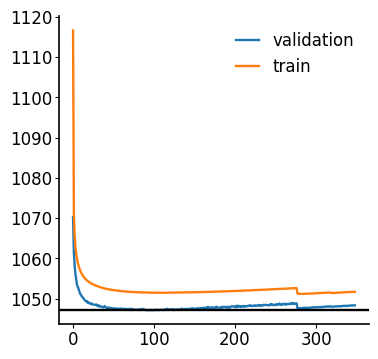

In [17]:
with mplscience.style_context():
    y = scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(scvi_model.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [18]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)


In [ ]:
scanvi_model.train(
    max_epochs=200,
    early_stopping=True,
    early_stopping_monitor="validation_classification_loss",  # or accuracy
    early_stopping_min_delta=0.001,
    early_stopping_patience=10,
    plan_kwargs={
        "reduce_lr_on_plateau": True,
        "lr_factor": 0.1,
        "lr_patience": 8,
        "lr_scheduler_metric": "validation_classification_loss",
    },
)

In [ ]:
# scanvi_model.save('full_scanvi_model')

In [4]:
scanvi_model = scvi.model.SCANVI.load('full_scanvi_model', adata)

INFO     File full_scanvi_model/model.pt already downloaded                                                        


In [8]:
scanvi_model.history.keys()

dict_keys(['lr-Adam', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'validation_classification_loss', 'validation_accuracy', 'validation_f1_score', 'validation_calibration_error', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_classification_loss', 'train_accuracy', 'train_f1_score', 'train_calibration_error'])

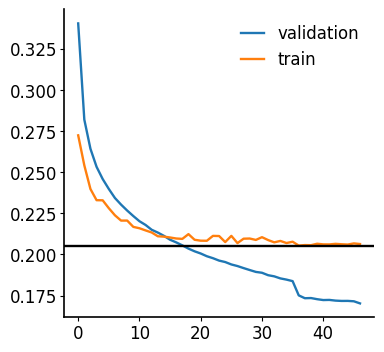

In [9]:
with mplscience.style_context():
    y = scanvi_model.history['validation_classification_loss']['validation_classification_loss'].min()
    plt.plot(scanvi_model.history['train_classification_loss']['train_classification_loss'], label = 'validation')
    plt.plot(scanvi_model.history['validation_classification_loss']['validation_classification_loss'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [ ]:
bdata = adata.raw.to_adata()
bdata

In [18]:
bdata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [19]:
bdata

AnnData object with n_obs × n_vars = 1135345 × 29437
    obs: 'author', 'method', 'assay', 'donor_id', 'gs_prediction_main', 'SingleR', 'predicted.annotation_level_3', 'predicted.annotation_level_4.score', 'predicted.annotation_level_4', 'copykat', 'cell_type', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scANVI'

In [20]:
bdata.write('map.h5ad')

In [21]:
np.max(bdata.X)

216739.0